In [ ]:
#preprocessing SANBS data

import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_csv("../1_data/private/SANBS Donations (3 Nov 2022).csv")


In [ ]:


#add a column OUTCOME_TYPE that indicates hgb deferal, other deferral or completed donation to indicate deferral type

df.loc[(df['Outcome'] == 'DEFERRAL') & (df["category"]=='Haematocrit/Haemoglobin'), 'OUTCOME_TYPE'] = 'low hgb'
df.loc[(df['Outcome'] == "SUCCESSFUL DONATION"), 'OUTCOME_TYPE'] = 'completed'
df.loc[(df['Outcome'] == "DEFERRAL") & (df["category"]!='Haematocrit/Haemoglobin') , 'OUTCOME_TYPE'] = 'other deferral'
df['OUTCOME_TYPE'].fillna("no draw", inplace=True)




In [ ]:

#add censored column (indicates whether row is right censored) 0-censored, 1-notcensored
df['CENSORED']=np.where(df['DonorID'] == df['DonorID'].shift(-1), 1, 0)

#add time_to_return column (time between visits)
#if return exists -> difference between visit dates
#else difference between visit date and end of data collection 2022-12-01

df.drop(df[df['Visit_Date'].isna()].index, inplace=True) #remove any missing visit dates

df["Visit_Date"] = df["Visit_Date"].astype("datetime64") #convert to date time object


df['time_to_return']= np.where(df['CENSORED']==1, (df['Visit_Date'].shift(-1)-df['Visit_Date'])/np.timedelta64(1, 'D'), (dt.datetime(2022, 12, 1)-df["Visit_Date"])/np.timedelta64(1, 'D'))
#df['time_to_return'].fillna((df['VISIT_DATE'].shift(-1)-df["VISIT_DATE"])/np.timedelta64(1, 'D'), inplace=True)

#remove permanent deferrals
df.drop(df[df.Deferral_permanent == 'Perm'].index, inplace=True)



In [ ]:
"""df['time_to_return'].mask(df['OUTCOME_TYPE']=='completed', (df['time_to_return'] - 56), inplace=True)
df['time_to_return'].mask(df['OUTCOME_TYPE']=='low hgb', (df['time_to_return'] - ((df['Def_end'] - df['Visit_Date'])/np.timedelta64(1, 'D'))), inplace=True)
df['time_to_return'].mask(df['OUTCOME_TYPE']=='other deferral', (df['time_to_return'] - ((df['Def_end'] - df['Visit_Date'])/np.timedelta64(1, 'D'))), inplace=True)
df['time_to_return'].isna().sum()"""

9746

In [ ]:
#compute time_to_return with shifts for completed donation: subtract 56 days 
df['time_to_return'] = np.where(df['OUTCOME_TYPE'] == 'completed', (df['time_to_return'] - 56), df['time_to_return'])

#compute time_to_return with shifts for other donations
#first covert eligibilty year and month to a datetime object

df["Def_end"] = df["Def_end"].astype("datetime64")


df['time_to_return'] = np.where(df['OUTCOME_TYPE'] == 'low hgb', (df['time_to_return'] - ((df['Def_end'] - df['Visit_Date'])/np.timedelta64(1, 'D'))), df['time_to_return'])

#df['time_to_return'] = np.where(df['OUTCOME_TYPE'] == 'other deferral', (df['time_to_return'] - ((df['Def_end'] - df['Visit_Date'])/np.timedelta64(1, 'D'))), df['time_to_return'])
df['time_to_return'].isna().sum()

9746

c:\Users\jagir\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Mobile Clinic          2306789
Fixed Clinic           1962798
Administrative Site      59595
Apheresis Clinic         29593
Laboratorium              7979
Lapsed Clinic               39
Processing Lab              24
Unallocated                 10
Doctor                       2
Name: Fixed, dtype: int64


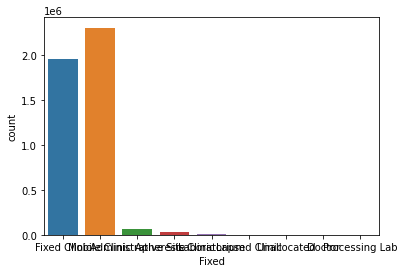

In [ ]:
#Fixed-Mobile Donations Analysis

#plot number - mobile=0, fixed=1
fixed=df["Fixed"]
sns.histplot(df, x="Fixed", stat="probability")
sns.countplot(fixed)
print(fixed.value_counts())

In [ ]:
df['time_to_return'].isnull().sum()




9746

In [ ]:
df.to_csv(("../1_data/private/preprocessed_data.csv"), index=False)
